# Differential abundance analysis in python with milopy

Edited by: Jiawei Wang & Jinzheng Ren

Date: 29/08/2024

Most of the materials originate from the [Differential abundance analysis in python with milopy](https://milopy.readthedocs.io/en/latest/milopy_example.html) with some of the text copied with a few edits.

In this notebook, we will demonstrate how to run differential abundance analysis on single-cell datasets using the python implementation of the Milo framework.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

In [4]:
import milopy.core as milo
import milopy.plot as milopl

## Load and prepare example dataset

In [5]:
# Remember to replace the following with your actual path.
adata = sc.read_h5ad('.../Caron_clustered.PBMMCandETV6RUNX1.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 30461 × 33102
    obs: 'Sample', 'Barcode', 'SampleName', 'SampleGroup', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'k.60_cluster.fun.leiden', 'label'
    var: 'ID', 'Symbol', 'Chromosome'
    obsm: 'X_corrected', 'X_tsne_corrected', 'X_umap_corrected'

## Dimension reduction using PCA

In [7]:
sc.pp.pca(adata, n_comps=50)

computing PCA
    with n_comps=50
    finished (0:00:47)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
adata

AnnData object with n_obs × n_vars = 30461 × 33102
    obs: 'Sample', 'Barcode', 'SampleName', 'SampleGroup', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'k.60_cluster.fun.leiden', 'label'
    var: 'ID', 'Symbol', 'Chromosome'
    uns: 'pca'
    obsm: 'X_corrected', 'X_tsne_corrected', 'X_umap_corrected', 'X_pca'
    varm: 'PCs'

In [9]:
adata.obsm['X_pca']

array([[-3.7379962e+02,  1.0943797e+02, -1.0292044e+02, ...,
         1.0800314e+00, -1.2628466e+01, -7.0739436e+00],
       [-3.7725174e+02,  2.9804520e+02, -2.6017865e+02, ...,
         1.1283192e+01, -6.9495673e+00,  9.2684298e+00],
       [-3.7309540e+02,  1.4131445e+02, -1.3050992e+02, ...,
        -1.0989344e+00,  6.7688799e+00, -7.6551566e+00],
       ...,
       [-3.6571576e+02,  3.0393326e+01, -3.6295319e+01, ...,
         2.2375739e+00, -1.0093134e+01, -5.3710878e-01],
       [-3.6367429e+02, -3.7343433e+01,  2.1219721e+01, ...,
        -3.2287958e+00, -3.6121745e+00,  1.1482913e-01],
       [-3.6571768e+02, -5.2768703e+01,  3.3478031e+01, ...,
         3.2707229e+00,  4.4563687e-01,  5.1955099e+00]], dtype=float32)

In [10]:
adata.obsm['X_pca'].shape

(30461, 50)

## Dimension reduction using UMAP

scanpy.tl.umap(): Embed the neighborhood graph using UMAP

UMAP (Uniform Manifold Approximation and Projection) is a manifold learning technique suitable for visualizing high-dimensional data. Besides tending to be faster than tSNE, it optimizes the embedding such that it best reflects the topology of the data, which we represent throughout Scanpy using a neighborhood graph. 

### Build KNN graph

We can use Scanpy functions to build a KNN graph. We set the dimensionality d and the value for k to use in subsequent steps. If adata.obsm["X_pca"] does not exist, PCA will be performed with the specified number of dimensions.

In [11]:
k = 60
d = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [12]:
adata

AnnData object with n_obs × n_vars = 30461 × 33102
    obs: 'Sample', 'Barcode', 'SampleName', 'SampleGroup', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'k.60_cluster.fun.leiden', 'label'
    var: 'ID', 'Symbol', 'Chromosome'
    uns: 'pca', 'neighbors'
    obsm: 'X_corrected', 'X_tsne_corrected', 'X_umap_corrected', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [13]:
adata.obsp['connectivities'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
adata.obsp['distances'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Perform UMAP

In [15]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


In [16]:
adata

AnnData object with n_obs × n_vars = 30461 × 33102
    obs: 'Sample', 'Barcode', 'SampleName', 'SampleGroup', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'k.60_cluster.fun.leiden', 'label'
    var: 'ID', 'Symbol', 'Chromosome'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_corrected', 'X_tsne_corrected', 'X_umap_corrected', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
adata.obsm['X_umap']

array([[-3.9190676, 10.968647 ],
       [-1.0819508, 12.998906 ],
       [-1.923735 , 11.620882 ],
       ...,
       [ 1.7247925,  8.036707 ],
       [ 2.955374 ,  4.3358884],
       [ 2.038852 ,  1.8815526]], dtype=float32)

In [18]:
adata.obsm['X_umap'].shape

(30461, 2)

## Plot UMAP 

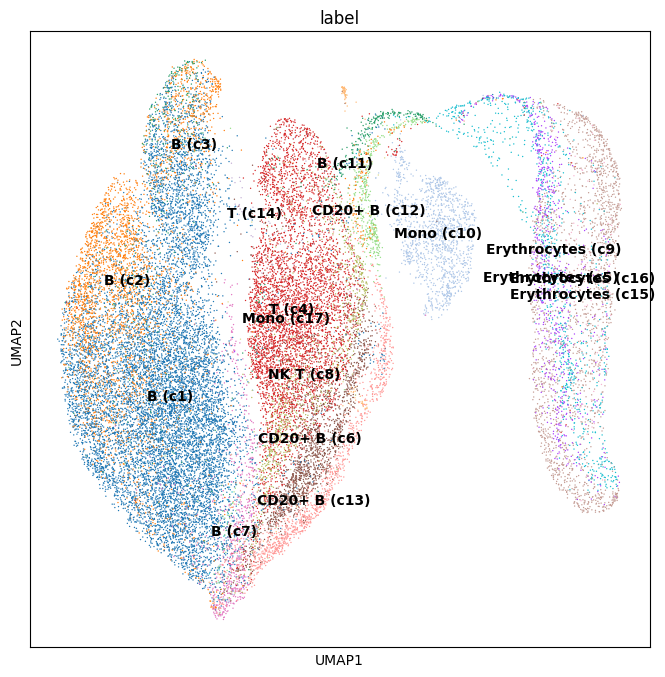

In [19]:
sc.pl.umap(adata, color=["label"], legend_loc="on data");

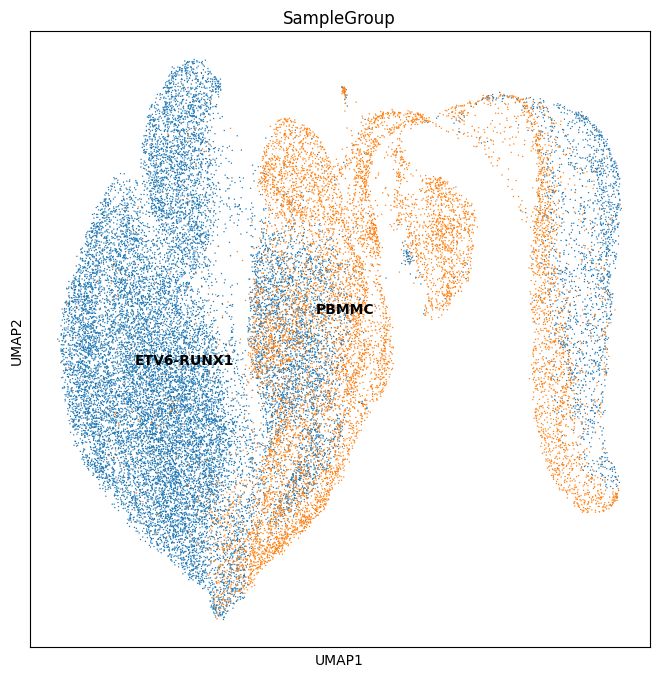

In [20]:
sc.pl.umap(adata, color=["SampleGroup"], legend_loc="on data");

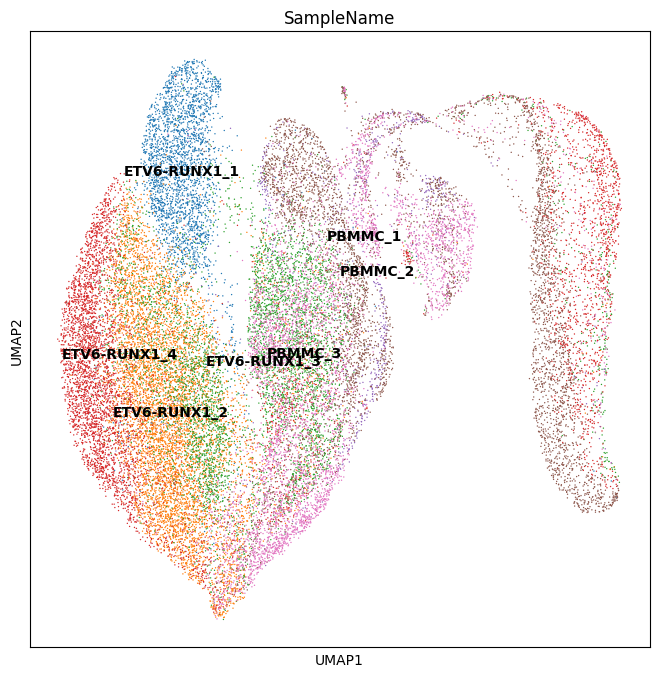

In [21]:
sc.pl.umap(adata, color=["SampleName"], legend_loc="on data");

## Construct neighbourhoods

This step assigns cells to a set of representative neighbourhoods on the KNN graph.

In [22]:
milo.make_nhoods(adata, prop=0.1)

In [23]:
adata

AnnData object with n_obs × n_vars = 30461 × 33102
    obs: 'Sample', 'Barcode', 'SampleName', 'SampleGroup', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'k.60_cluster.fun.leiden', 'label', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    var: 'ID', 'Symbol', 'Chromosome'
    uns: 'pca', 'neighbors', 'umap', 'label_colors', 'SampleGroup_colors', 'SampleName_colors', 'nhood_neighbors_key'
    obsm: 'X_corrected', 'X_tsne_corrected', 'X_umap_corrected', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

The assignment of cells to neighbourhoods is stored as a sparse binary matrix in adata.obsm. Here we see that cells have been assigned to 2270 neighbourhoods.

In [24]:
adata.obsm["nhoods"]

<30461x2270 sparse matrix of type '<class 'numpy.float32'>'
	with 261519 stored elements in Compressed Sparse Row format>

The information on which cells are sampled as index cells of representative neighbourhoods is stored in adata.obs, along with the distance of the index to the kth nearest neighbor, which is used later for the SpatialFDR correction.



In [25]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
1_AAACCTGGTCTTCAAG-1,1,216.788864
1_AAGCCGCCACGGACAA-1,1,107.869232
1_AAGGAGCAGAAACCAT-1,1,49.668110
1_AAGTCTGTCGCGCCAA-1,1,63.480961
1_AATCCAGGTACCCAAT-1,1,119.186714
...,...,...
11_TTGACTTAGAGAACAG-1,1,19.475857
11_TTGCCGTAGTGTTGAA-1,1,71.884331
11_TTGCGTCGTCCGAATT-1,1,30.142151
11_TTTACTGAGCGGATCA-1,1,145.460739


We can visualize the distribution of neighbourhood sizes to get an idea of the right value for k

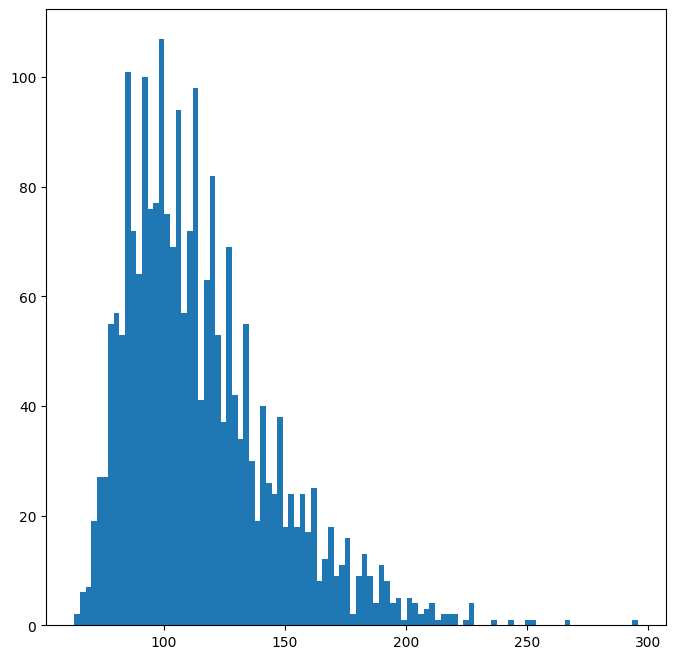

In [26]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

## Count cells in neighbourhoods

Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. Therefore we have to count how many cells from each sample are in each neighbourhood. We need to use the cell metadata saved in adata.obs and specify which column contains the sample information.

In [27]:
milo.count_nhoods(adata, sample_col="SampleName")

This function adds adata.uns["nhood_adata"], that stores an anndata object where obs correspond to neighbourhoods and vars correspond to samples, and where .X stores the number of cells from each sample counted in a neighbourhood. This count matrix will be used for DA testing.

In [28]:
adata

AnnData object with n_obs × n_vars = 30461 × 33102
    obs: 'Sample', 'Barcode', 'SampleName', 'SampleGroup', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'k.60_cluster.fun.leiden', 'label', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    var: 'ID', 'Symbol', 'Chromosome'
    uns: 'pca', 'neighbors', 'umap', 'label_colors', 'SampleGroup_colors', 'SampleName_colors', 'nhood_neighbors_key', 'nhood_adata'
    obsm: 'X_corrected', 'X_tsne_corrected', 'X_umap_corrected', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:
adata.uns['nhood_adata']

AnnData object with n_obs × n_vars = 2270 × 7
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [30]:
adata.uns['nhood_adata'].obs

,index_cell,kth_distance
0,1_AAACCTGGTCTTCAAG-1,216.788864
1,1_AAGCCGCCACGGACAA-1,107.869232
2,1_AAGGAGCAGAAACCAT-1,49.668110
3,1_AAGTCTGTCGCGCCAA-1,63.480961
4,1_AATCCAGGTACCCAAT-1,119.186714
...,...,...
2265,11_TTGACTTAGAGAACAG-1,19.475857
2266,11_TTGCCGTAGTGTTGAA-1,71.884331
2267,11_TTGCGTCGTCCGAATT-1,30.142151
2268,11_TTTACTGAGCGGATCA-1,145.460739


In [31]:
adata.uns['nhood_adata'].X

<2270x7 sparse matrix of type '<class 'numpy.float32'>'
	with 9782 stored elements in Compressed Sparse Column format>

## Differential abundance testing with GLM

In [32]:
milo.DA_nhoods(adata, design="~SampleGroup")

The differential abundance test results are stored in adata.uns["nhood_adata"].obs. In particular:

* logFC: stores the log-Fold Change in abundance (i.e. the slope of the linear model)

* PValue stores the p-value for the test

* SpatialFDR stores the p-values adjusted for multiple testing (accounting for overlap between neighbourhoods)

In [34]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,1_AAACCTGGTCTTCAAG-1,216.788864,-6.968409,9.818165,3.932925,0.052284,0.127892,0.130672
1,1_AAGCCGCCACGGACAA-1,107.869232,-6.063739,10.205674,2.706899,0.105337,0.187101,0.196017
2,1_AAGGAGCAGAAACCAT-1,49.668110,-9.520814,10.577676,3.520179,0.066064,0.142533,0.147740
3,1_AAGTCTGTCGCGCCAA-1,63.480961,-9.169593,10.241567,4.043883,0.049349,0.125025,0.127204
4,1_AATCCAGGTACCCAAT-1,119.186714,-6.416656,10.135786,3.088788,0.084180,0.164135,0.169767
...,...,...,...,...,...,...,...,...
2265,11_TTGACTTAGAGAACAG-1,19.475857,8.391108,9.124083,10.179446,0.002401,0.085254,0.085317
2266,11_TTGCCGTAGTGTTGAA-1,71.884331,5.894451,8.909283,7.413349,0.008547,0.085254,0.085317
2267,11_TTGCGTCGTCCGAATT-1,30.142151,1.436649,8.063386,0.486039,0.488290,0.589271,0.603274
2268,11_TTTACTGAGCGGATCA-1,145.460739,4.776416,8.976095,5.440174,0.023007,0.091048,0.090009


We can start inspecting the results of our DA analysis from a couple of standard diagnostic plots.

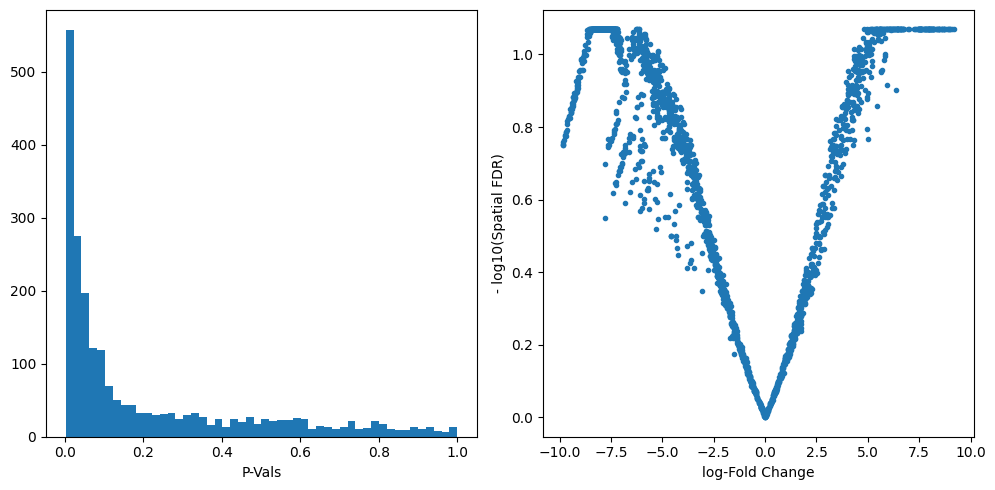

In [35]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

## Visualize results on embedding

To visualize DA results relating them to the embedding of single cells, we can build an abstracted graph of neighbourhoods that we can superimpose on the single-cell embedding. Here each node represents a neighbourhood, while edges indicate how many cells two neighbourhoods have in common. Here the layout of nodes is determined by the position of the index cell in the UMAP embedding of all single-cells. The neighbourhoods displaying singificant DA are colored by their log-Fold Change.

In [36]:
import milopy.utils
milopy.utils.build_nhood_graph(adata)

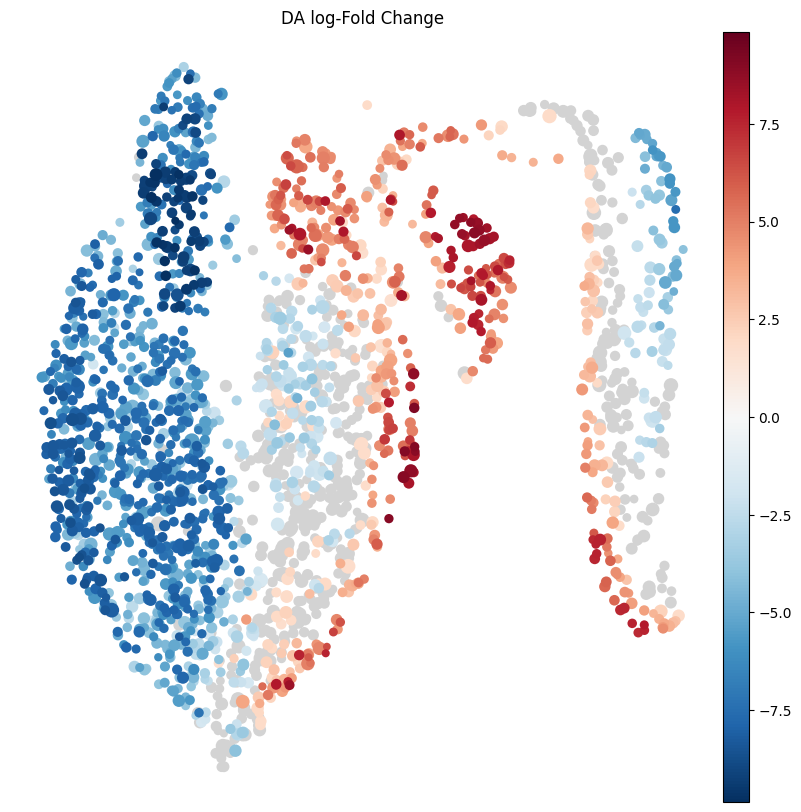

In [45]:
plt.rcParams["figure.figsize"] = [10,10]
milopl.plot_nhood_graph(adata, 
                        alpha=0.1, ## SpatialFDR level (10%) 
                        min_size=2 ## Size of smallest dot
                       )

## Visualize result by celltype

We might want to visualize whether DA is particularly evident in certain cell types. To do this, we assign a cell type label to each neighbourhood by finding the most abundant cell type within cells in each neighbourhood (after all, neighbourhoods are in most cases small subpopulations within the same cell type). We can label neighbourhoods in the results data.frame using the function milopy.core.annotate_nhoods. This also saves the fraction of cells harbouring the label.

In [48]:
milopy.utils.annotate_nhoods(adata, anno_col='label')

Text(0.5, 0, 'celltype fraction')

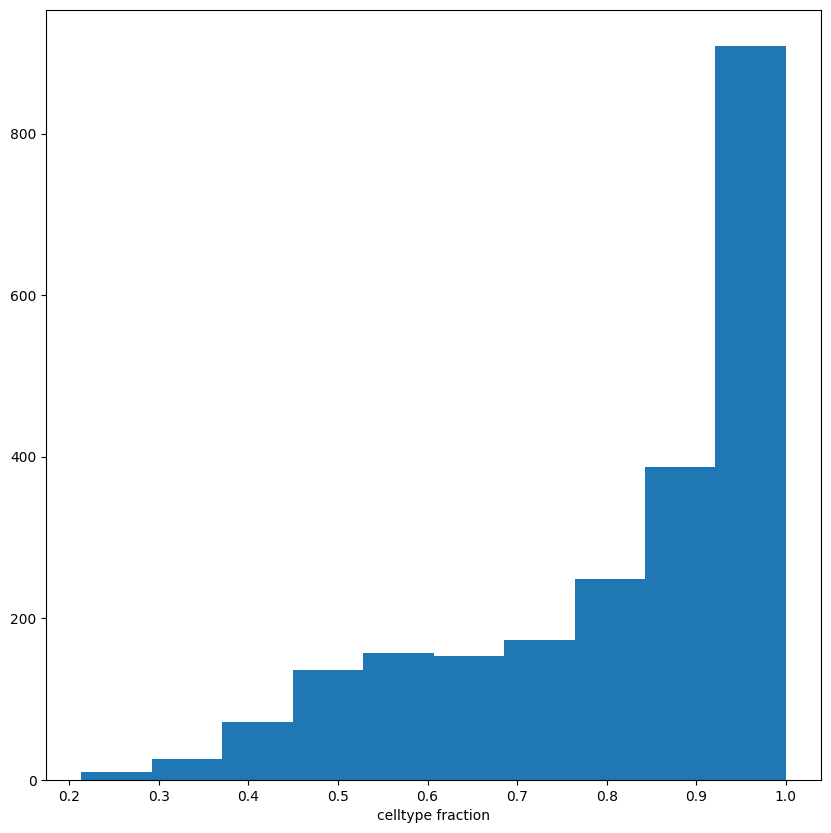

In [49]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

Now we can plot the fold changes using standard scanpy functions

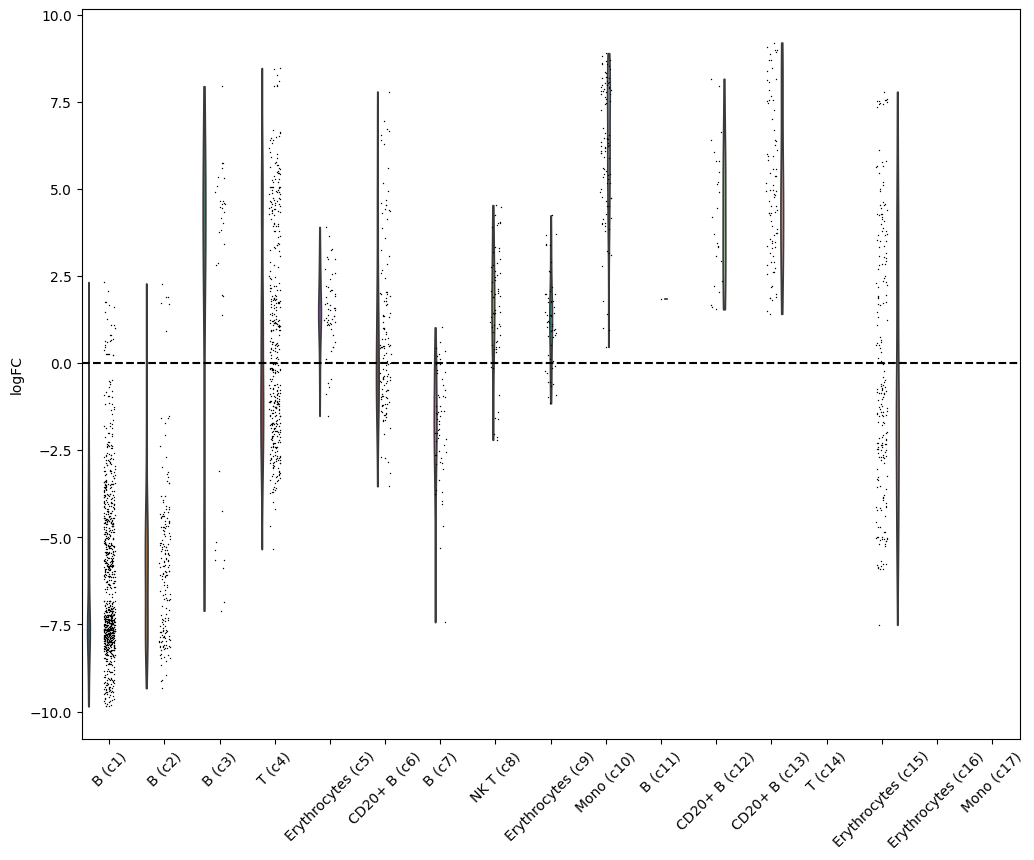

In [54]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=45, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()